In [2]:
import sys

# laptop
sys.path.append( '/home/greg/current/GitHub/' )
af_path = '/home/greg/data/rawdata/NMEG/FLUXNET2015_a/'
af_path_old = '/home/greg/data/rawdata/NMEG/FLUXNET2015/'

import os
import NMEG_utils.py_modules.load_nmeg as ld
import NMEG_utils.py_modules.transform_nmeg as tr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
% matplotlib inline

## Laura Morillas data

In [3]:
# Read Laura's data in and select which to use.

path = "/home/greg/data/Dropbox/Manuscripts/PJ_Laura/FINAL_DATABASIS_old/"
pjc_laura = pd.read_csv( path + "PJC_ECDaily_Transp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date'  )
pjg_laura = pd.read_csv( path + "PJG_ECDaily_Transp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date')
pjc_lauraftp = pd.read_csv( path + "PJC_ECDaily_Transp_ftp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date'  )
pjg_lauraftp = pd.read_csv( path + "PJG_ECDaily_Transp_ftp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date')
Dropbox = "/home/greg/data/Dropbox/Manuscripts/PJ_Laura/shared with greg/All INPUT FILES FOR PLOTS/"
pjc_lauraDrop = pd.read_csv( Dropbox + "PJC_EC_Daytime&24h_Transp.csv", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date'  )
pjg_lauraDrop = pd.read_csv( Dropbox + "PJG_EC_Daytime&24h_Transp.csv", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date')

pjc_l = pjc_lauraDrop
pjg_l = pjg_lauraDrop

## Greg Maurer data

Note that earlier versions of this notebook contained data that had an erroneous correction applied to LE in 2009 at PJG. This made ET look substantially higher at the site as compared to PJC during the same time. This correction is removed in the current generation of Ameriflux files.

see [this notebook](PJG_2009_ET&LE_issues.ipynb) for more info

In [4]:

# Years to load
starty = 2009
endy = 2013
# Sites to load
sites = ['Mpj', 'Mpg']

# Fill a dict with multiyear dataframes for each site in sites
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path, gapfilled=True, startyear=starty, endyear=endy) 
          for x in sites }

# Also get old hourly files
hourly_old = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path_old, gapfilled=True, startyear=starty, endyear=endy) 
          for x in sites }

# Open local daily files
daily_path = '/home/greg/current/GitHub/NMEG_utils/processed_data/daily_aflx/'
daily = { x : 
         ld.load_local_file( daily_path + 'FLUXNET2015_a/' + 'US-' + x + '_daily_aflx.csv', yrtrim=[2009,2013])
         for x in sites }
d = pd.Panel(daily)

# Resample all hourly_old dataframes to daily and add to dict
# This produces 24 hour ET values
daily_o = { x : 
           ld.load_local_file( daily_path + 'FLUXNET2015/' + 'US-' + x + '_daily_aflx.csv', yrtrim=[2009,2013])
           for x in sites }
           #tr.resample_30min_aflx( hourly_old[x], freq='1D',
           #                       c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
           #                       le_flux=[ 'LE_F' ], 
           #                       avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
           #                       sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
           #for x in hourly_old.keys() }
d_o = pd.Panel(daily_o)

Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015_a/US-Mpj_2009_gapfilled.txt
Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015_a/US-Mpj_2010_gapfilled.txt
Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015_a/US-Mpj_2011_gapfilled.txt
Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015_a/US-Mpj_2012_gapfilled.txt
Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015_a/US-Mpj_2013_gapfilled.txt
Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015_a/US-Mpg_2010_gapfilled.txt
Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015_a/US-Mpg_2011_gapfilled.txt
Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015_a/US-Mpg_2012_gapfilled.txt
Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015_a/US-Mpg_2013_gapfilled.txt
Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015/US-Mpj_2009_gapfilled.txt
Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015/US-Mpj_2010_gapfilled.txt
Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015/US-Mpj_2011_gapfilled.txt
Parsing /home/greg/data/rawdata/NMEG/FLUXNET2015/US-Mpj_2012_gapfilled.txt
Parsing

Index(['GPP_g_int', 'RECO_g_int', 'FC_F_g_int', 'ET_mm_24hint_0', 'P_F_sum',
       'TA_F_avg', 'RH_F_avg', 'SW_IN_F_avg', 'RNET_F_avg', 'VPD_F_avg',
       'PAR_avg', 'LE_F_avg', 'H_F_avg', 'LE_F_int', 'H_F_int', 'TA_F_min',
       'VPD_F_min', 'TA_F_max', 'VPD_F_max', 'ET_mm_dayint', 'PET_mm_dayint'],
      dtype='object')
Index(['GPP_g_int', 'RECO_g_int', 'FC_F_g_int', 'ET_mm_24hint_0', 'P_F_sum',
       'TA_F_avg', 'RH_F_avg', 'SW_IN_F_avg', 'RNET_F_avg', 'VPD_F_avg',
       'PAR_avg', 'LE_F_avg', 'H_F_avg', 'LE_F_int', 'H_F_int', 'TA_F_min',
       'VPD_F_min', 'TA_F_max', 'VPD_F_max', 'ET_mm_dayint', 'PET_mm_dayint'],
      dtype='object')


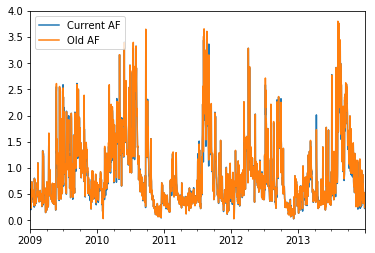

In [5]:
# Compare old data and the uncorrected ET data
print(d.minor_axis)
print(d_o.minor_axis)
d.Mpj.ET_mm_24hint_0.plot()
d_o.Mpj.ET_mm_24hint_0.plot()
plt.legend(['Current AF', 'Old AF'])

## Compare ET and P

In [22]:
# ET
df_ET = pd.DataFrame( index = np.asarray(range(starty, endy)))
df_ET_day = pd.DataFrame( index = np.asarray(range(starty, endy)))
df_P = pd.DataFrame( index = np.asarray(range(starty, endy)))

# This is summed raw ET numbers from Laura and Greg's data
gby = d.Mpg.ET_mm_24hint_0.groupby(d.Mpg.index.year)
df_ET['Girdle ET(Greg)'] = gby.sum()
gby = d.Mpj.ET_mm_24hint_0.groupby(d.Mpj.index.year)
df_ET['Control ET(Greg)'] = gby.sum()
gby = pjg_l.ET.groupby(pjg_l.index.year)
df_ET['Girdle ET(Laura)'] = gby.sum()
gby = pjc_l.ET.groupby(pjc_l.index.year)
df_ET['Control ET(Laura)'] = gby.sum()
# This is ET calculated on a daily basis from daytime LE/Tair values only (SW_IN > 5)
gby = d.Mpg.ET_mm_dayint.groupby(d.Mpg.index.year)
df_ET_day['Girdle et_day(Greg)'] = gby.sum()
gby = d.Mpj.ET_mm_dayint.groupby(d.Mpj.index.year)
df_ET_day['Control et_day(Greg)'] = gby.sum()
gby = pjg_l.ET_Dayt.groupby(pjg_l.index.year)
df_ET_day['Girdle ET_Dayt(Laura)'] = gby.sum()
gby = pjc_l.ET_Dayt.groupby(pjc_l.index.year)
df_ET_day['Control ET_Dayt(Laura)'] = gby.sum()
# Precip
gby = d.Mpg.P_F_sum.groupby(d.Mpg.index.year)
df_P['Girdle Precip (Greg)'] = gby.sum()
gby = d.Mpj.P_F_sum.groupby(d.Mpj.index.year)
df_P['Control Precip(Greg)'] = gby.sum()
gby = pjg_l.PRECIP.groupby(pjg_l.index.year)
df_P['Girdle Precip(Laura)'] = gby.sum()
gby = pjc_l.PRECIP.groupby(pjc_l.index.year)
df_P['Control Precip(Laura)'] = gby.sum()

In [23]:
# This is summed raw ET numbers from Laura and Greg's data
df_ET

,Girdle ET(Greg),Control ET(Greg),Girdle ET(Laura),Control ET(Laura)
2009,319.246872,313.949642,374.166232,320.486766
2010,389.742640,401.358296,392.321345,404.886621
2011,252.362324,274.505889,256.110038,281.656078
2012,262.063456,297.506737,251.740634,300.457563


In [24]:
# This is ET calculated on a daily basis from daytime LE/Tair values only (SW_IN > 5)
df_ET_day

,Girdle et_day(Greg),Control et_day(Greg),Girdle ET_Dayt(Laura),Control ET_Dayt(Laura)
2009,300.913896,300.945527,346.796318,307.329569
2010,373.242056,385.491773,374.948771,387.112575
2011,243.592706,266.440721,245.743733,271.108398
2012,247.586508,288.906656,233.097157,291.429758


In [25]:
df_P

,Girdle Precip (Greg),Control Precip(Greg),Girdle Precip(Laura),Control Precip(Laura)
2009,322.93017,329.45052,297.942,329.200000
2010,347.98000,328.92627,347.980,328.926008
2011,255.77800,273.80000,255.778,273.600000
2012,157.24000,180.30000,151.892,165.500000


## Compare ET and P (Hydrological year basis)

In [20]:
newg[200:300]

,GPP_g_int,RECO_g_int,FC_F_g_int,ET_mm_24hint_0,P_F_sum,TA_F_avg,RH_F_avg,SW_IN_F_avg,RNET_F_avg,VPD_F_avg,...,H_F_int,TA_F_min,VPD_F_min,TA_F_max,VPD_F_max,ET_mm_dayint,PET_mm_dayint,year_w,doy_w,season
2009-07-20,0.450200,1.475080,1.024880,1.605242,0.50800,23.282783,32.393431,336.034899,199.421615,2.096068,...,9.561681e+06,15.93404,0.634661,29.92072,3.584107,1.517831,3.539153,2009,293,monsoon
2009-07-21,1.410669,1.714981,0.304312,0.735497,28.19400,18.594381,58.919938,242.333982,148.879248,0.982988,...,7.753324e+06,13.17959,0.080161,25.02206,2.108137,0.618072,2.040898,2009,294,monsoon
2009-07-22,1.339243,1.837448,0.498206,1.623976,0.25400,16.451609,77.934141,277.868418,194.517242,0.490580,...,7.706877e+06,13.16695,0.057302,21.50425,1.323577,1.572279,2.790224,2009,295,monsoon
2009-07-23,1.220182,2.327053,1.106870,2.741707,0.00000,18.870201,58.701308,346.523821,216.713033,1.109132,...,8.070664e+06,9.19103,0.049961,25.98250,2.603915,2.655962,4.026156,2009,296,monsoon
2009-07-24,1.622540,2.622350,0.999809,2.186580,0.00000,21.722699,45.471794,288.622432,149.601489,1.556902,...,6.151536e+06,15.51177,0.413090,27.62595,2.766701,2.038548,3.233353,2009,297,monsoon
2009-07-25,1.643189,2.945862,1.302673,1.954309,0.00000,24.027376,33.579456,352.137812,193.040351,2.114794,...,9.111178e+06,18.99758,0.914055,30.01916,3.533878,1.833084,3.744829,2009,298,monsoon
2009-07-26,2.081926,2.631577,0.549651,1.466996,4.82600,20.709508,56.100927,286.691983,176.699250,1.273632,...,8.761064e+06,15.09446,0.217271,29.01651,3.147436,1.435666,3.160075,2009,299,monsoon
2009-07-27,2.085941,2.899998,0.814057,2.308422,0.00000,19.850398,59.047516,350.321457,210.833258,1.086251,...,8.101037e+06,14.03936,0.289211,26.80081,2.511417,2.166094,3.648647,2009,300,monsoon
2009-07-28,2.470273,3.102234,0.631962,1.634368,0.00000,20.916573,48.530227,277.421044,149.467842,1.440901,...,7.133488e+06,15.42579,0.360573,29.12653,3.347096,1.547194,2.900567,2009,301,monsoon
2009-07-29,2.614689,2.875522,0.260833,1.885433,2.79400,19.512202,46.379126,293.077658,154.111875,1.322229,...,7.065284e+06,13.63931,0.500385,26.90283,2.772334,1.816518,3.090069,2009,302,monsoon


In [19]:
# ET
import imp
imp.reload(tr)
df_ET = pd.DataFrame( index = np.asarray(range(starty, endy)))
df_ET_day = pd.DataFrame( index = np.asarray(range(starty, endy)))
df_P = pd.DataFrame( index = np.asarray(range(starty, endy)))

# Add wateryear to dataframes
newg = tr.add_WY_cols(d.Mpg)
newc = tr.add_WY_cols(d.Mpj)
d_h = pd.Panel({'Mpg':newg, 'Mpj':newc})
print(d_h.Mpj.columns)

# This is summed raw ET numbers from Laura and Greg's data
gby = d.Mpg.ET_mm_24hint_0.groupby(d_h.Mpg.year_w)
df_ET['Girdle ET(Greg)'] = gby.sum()
gby = d.Mpj.ET_mm_24hint_0.groupby(d_h.Mpj.year_w)
df_ET['Control ET(Greg)'] = gby.sum()
gby = pjg_l.ET.groupby(pjg_l.Year_H)
df_ET['Girdle ET(Laura)'] = gby.sum()
gby = pjc_l.ET.groupby(pjc_l.Year_H)
df_ET['Control ET(Laura)'] = gby.sum()
# This is ET calculated on a daily basis from daytime LE/Tair values only (SW_IN > 5)
gby = d.Mpg.ET_mm_dayint.groupby(d_h.Mpg.year_w)
df_ET_day['Girdle et_day(Greg)'] = gby.sum()
gby = d.Mpj.ET_mm_dayint.groupby(d_h.Mpj.year_w)
df_ET_day['Control et_day(Greg)'] = gby.sum()
gby = pjg_l.ET_Dayt.groupby(pjg_l.Year_H)
df_ET_day['Girdle ET_Dayt(Laura)'] = gby.sum()
gby = pjc_l.ET_Dayt.groupby(pjc_l.Year_H)
df_ET_day['Control ET_Dayt(Laura)'] = gby.sum()
# Precip
gby = d.Mpg.P_F_sum.groupby(d_h.Mpg.year_w)
df_P['Girdle Precip (Greg)'] = gby.sum()
gby = d.Mpj.P_F_sum.groupby(d_h.Mpj.year_w)
df_P['Control Precip(Greg)'] = gby.sum()
gby = pjg_l.PRECIP.groupby(pjg_l.Year_H)
df_P['Girdle Precip(Laura)'] = gby.sum()
gby = pjc_l.PRECIP.groupby(pjc_l.Year_H)
df_P['Control Precip(Laura)'] = gby.sum()

Index(['GPP_g_int', 'RECO_g_int', 'FC_F_g_int', 'ET_mm_24hint_0', 'P_F_sum',
       'TA_F_avg', 'RH_F_avg', 'SW_IN_F_avg', 'RNET_F_avg', 'VPD_F_avg',
       'PAR_avg', 'LE_F_avg', 'H_F_avg', 'LE_F_int', 'H_F_int', 'TA_F_min',
       'VPD_F_min', 'TA_F_max', 'VPD_F_max', 'ET_mm_dayint', 'PET_mm_dayint',
       'year_w', 'doy_w', 'season'],
      dtype='object')


In [21]:
df_ET

,Girdle ET(Greg),Control ET(Greg),Girdle ET(Laura),Control ET(Laura)
2009,248.071330,237.574348,295.454352,244.226649
2010,413.674704,432.470093,423.647656,436.294479
2011,236.860594,262.566562,239.453098,268.244237
2012,288.892243,316.938970,278.965613,320.234339


In [22]:
# This is ET calculated on a daily basis from daytime LE/Tair values only (SW_IN > 5)
df_ET_day

,Girdle et_day(Greg),Control et_day(Greg),Girdle ET_Dayt(Laura),Control ET_Dayt(Laura)
2009,236.863530,231.481946,277.398003,237.883761
2010,390.735310,410.454072,397.673105,412.535351
2011,232.842003,257.742597,234.826790,261.970257
2012,272.179097,305.337933,255.633634,307.168010


In [23]:
df_P

,Girdle Precip (Greg),Control Precip(Greg),Girdle Precip(Laura),Control Precip(Laura)
2009,243.31183,251.39122,224.028,251.200000
2010,388.73634,375.98557,383.032,375.926008
2011,196.85000,208.40000,196.850,208.200000
2012,228.09200,249.10000,225.044,234.300000


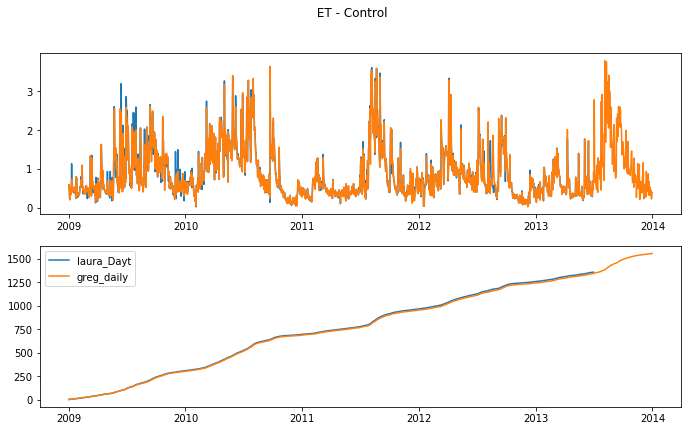

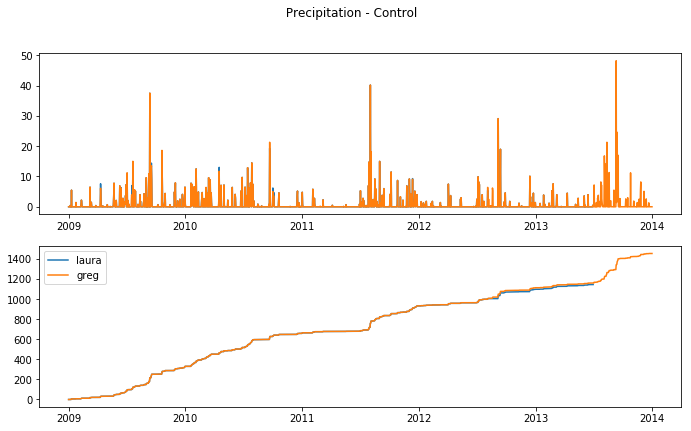

In [31]:
# ET
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjc_l.index, pjc_l.ET)
#plt.plot(pjc_l.index, pjc_l.ET)
plt.plot(d.Mpj.index, d.Mpj.ET_mm_24hint_0)
#plt.plot(d.Mpj.index, d.Mpj.ET_mm_int_0)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjc_l.index, pjc_l.ET_Dayt.cumsum())
#plt.plot(pjc_l.index, pjc_l.ET.cumsum())
plt.plot(d.Mpj.index, d.Mpj.ET_mm_dayint.cumsum())
#plt.plot(d.Mpj.index, d.Mpj.ET_mm_int_0.cumsum())
plt.legend(['laura_Dayt', 'greg_daily'], loc='upper left')
plt.suptitle(' ET - Control')
plt.show()

# Precip
plt.figure(2, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjc_l.index, pjc_l.PRECIP)
plt.plot(d.Mpj.index, d.Mpj.P_F_sum)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjc_l.index, pjc_l.PRECIP.cumsum())
plt.plot(d.Mpj.index, d.Mpj.P_F_sum.cumsum())
plt.legend(['laura', 'greg'], loc='upper left')
plt.suptitle(' Precipitation - Control')
plt.show()

## Plot comparisons for girdle

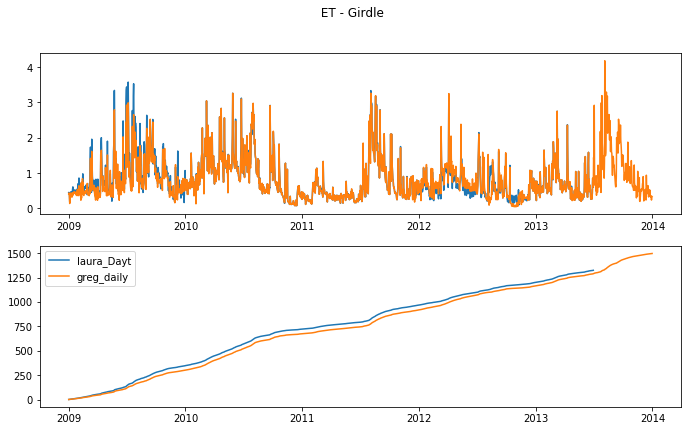

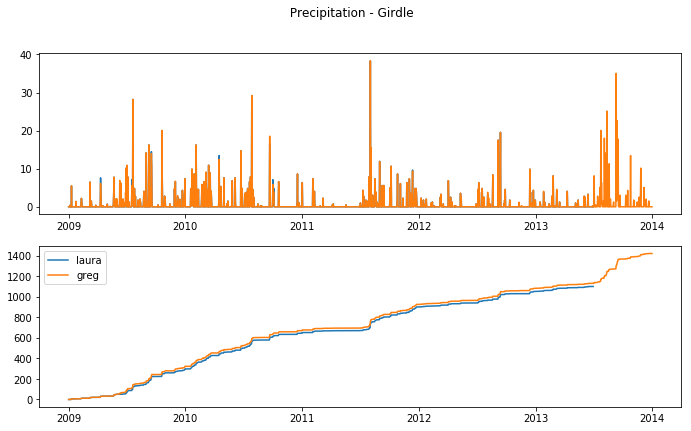

In [32]:
# ET
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjg_l.index, pjg_l.ET_Dayt)
#plt.plot(pjg_lindex, pjg_lET)
plt.plot(d.Mpg.index, d.Mpg.ET_mm_dayint)
#plt.plot(d.Mpg.index, d.Mpg.ET_mm_int_0)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjg_l.index, pjg_l.ET_Dayt.cumsum())
#plt.plot(pjg_lindex, pjg_lET.cumsum())
plt.plot(d.Mpg.index, d.Mpg.ET_mm_dayint.cumsum())
#plt.plot(d.Mpg.index, d.Mpg.ET_mm_int_0.cumsum())
plt.legend(['laura_Dayt', 'greg_daily'], loc='upper left')
plt.suptitle(' ET - Girdle')
plt.show()

# Precip
plt.figure(2, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjg_l.index, pjg_l.PRECIP)
plt.plot(d.Mpg.index, d.Mpg.P_F_sum)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjg_l.index, pjg_l.PRECIP.cumsum())
plt.plot(d.Mpg.index, d.Mpg.P_F_sum.cumsum())
plt.legend(['laura', 'greg'], loc='upper left')
plt.suptitle(' Precipitation - Girdle')
plt.show()

## Gapfilling

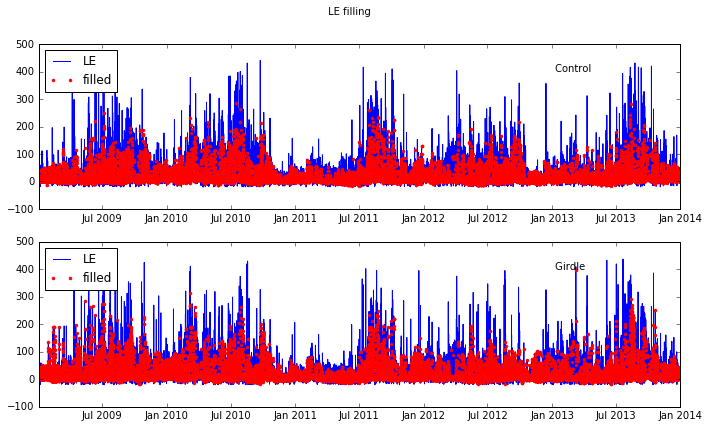

In [95]:
# LE - recent files
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(hourly['Mpj'].index, hourly['Mpj'].LE_F)
test = hourly['Mpj'].LE_F_FLAG==1
plt.plot(hourly['Mpj'].index[test], hourly['Mpj'].loc[test, 'LE_F'], 
         color='red', marker='.', ls='')
plt.legend(['LE', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 400, ' Control ')
plt.suptitle(' LE filling ')

ax2 = plt.subplot(2, 1, 2)
plt.plot(hourly['Mpg'].index, hourly['Mpg'].LE_F)
test = hourly['Mpg'].LE_F_FLAG==1
plt.plot(hourly['Mpg'].index[test], hourly['Mpg'].loc[test, 'LE_F'], 
         color='red', marker='.', ls='')
plt.legend(['LE', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 400, ' Girdle ')
plt.show()

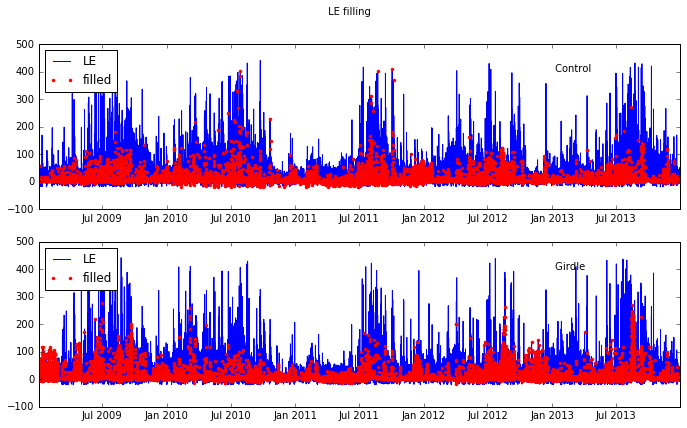

In [96]:
# LE - previous AF files
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(hourly_old['Mpj'].index, hourly_old['Mpj'].LE_F)
test = hourly_old['Mpj'].LE_flag==1
plt.plot(hourly_old['Mpj'].index[test], hourly_old['Mpj'].loc[test, 'LE_F'], 
         color='red', marker='.', ls='')
plt.legend(['LE', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 400, ' Control ')
plt.suptitle(' LE filling ')

ax2 = plt.subplot(2, 1, 2)
plt.plot(hourly_old['Mpg'].index, hourly_old['Mpg'].LE_F)
test = hourly_old['Mpg'].LE_flag==1
plt.plot(hourly_old['Mpg'].index[test], hourly_old['Mpg'].loc[test, 'LE_F'], 
         color='red', marker='.', ls='')
plt.legend(['LE', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 400, ' Girdle ')
plt.show()

### Percent LE gapfilled

In [97]:
df = pd.DataFrame()
gby = hourly['Mpj'].LE_F_FLAG.groupby(hourly['Mpj'].index.year)
df['Mpj %gf'] = gby.sum() / gby.count()
gby = hourly['Mpg'].LE_F_FLAG.groupby(hourly['Mpg'].index.year)
df['Mpg %gf'] = gby.sum() / gby.count()
#gby = hourly_old['Mpj'].LE_flag.groupby(hourly_old['Mpj'].index.year)
#df['Mpj_old'] = gby.sum() / gby.count()
#gby = hourly_old['Mpg'].LE_flag.groupby(hourly_old['Mpg'].index.year)
#df['Mpg_old'] = gby.sum() / gby.count()

### Nighttime LE gapfilling

(87648, 33)
(44138, 33)
(87648, 33)
(43992, 33)


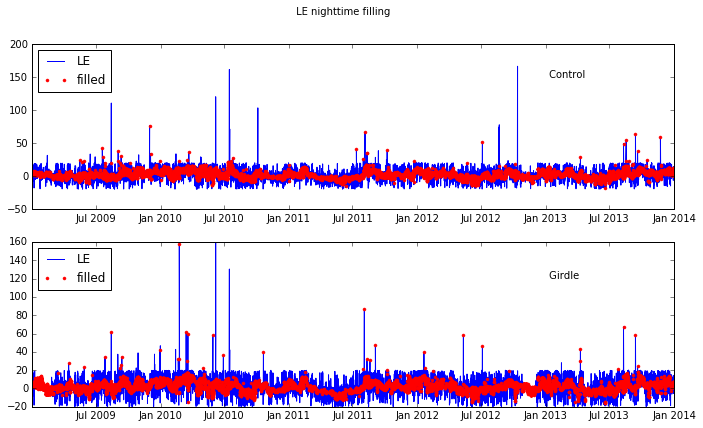

In [98]:
# Extract nighttime data into new dataframes and plot
print(hourly['Mpj'].shape)
pj_night_test = np.logical_or(hourly['Mpj'].PAR < 20, hourly['Mpj'].SW_IN_F < (20*.48))
pj_night = hourly['Mpj'].loc[pj_night_test]
print(pj_night.shape)
print(hourly['Mpg'].shape)
pjg_night_test = np.logical_or(hourly['Mpg'].PAR < 20, hourly['Mpg'].SW_IN_F < (20*.48))
pjg_night = hourly['Mpg'].loc[pjg_night_test]
print(pjg_night.shape)

# LE - recent files
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pj_night.index, pj_night.LE_F)
test = pj_night.LE_F_FLAG==1
plt.plot(pj_night.index[test], pj_night.loc[test, 'LE_F'], 
         color='red', marker='.', ls='')
plt.legend(['LE', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 150, ' Control ')
plt.suptitle(' LE nighttime filling ')

ax2 = plt.subplot(2, 1, 2)
plt.plot(pjg_night.index, pjg_night.LE_F)
test = pjg_night.LE_F_FLAG==1
plt.plot(pjg_night.index[test], pjg_night.loc[test, 'LE_F'], 
         color='red', marker='.', ls='')
plt.legend(['LE', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 120, ' Girdle ')
plt.show()

In [99]:
# Put nighttime values in table
gby = pj_night.LE_F.groupby(pj_night.index.year)
df['Mpj night Avg val'] = gby.mean()
gby_g = pjg_night.LE_F.groupby(pjg_night.index.year)
df['Mpg night Avg val'] = gby_g.mean()
df['Mpj night max val'] = gby.max()
df['Mpg night min val'] = gby_g.min()

# Calculate percentage of night values gapfilled
gby = pj_night.LE_F_FLAG.groupby(pj_night.index.year)
df['Mpj night %gf'] = gby.sum() / gby.count()
gby_g = pjg_night.LE_F_FLAG.groupby(pjg_night.index.year)
df['Mpg night %gf'] = gby_g.sum() / gby_g.count()

# Now get gapfilled only values
print(pj_night.shape)
pj_night_gf_test = pj_night.LE_F_FLAG > 0
pj_night_gf = pj_night.loc[pj_night_gf_test]
print(pj_night_gf.shape)
print(pjg_night.shape)
pjg_night_gf_test = pjg_night.LE_F_FLAG > 0
pjg_night_gf = pjg_night.loc[pjg_night_gf_test]
print(pjg_night_gf.shape)

gby = pj_night_gf.LE_F.groupby(pj_night_gf.index.year)
df['Mpj night gf mean'] = gby.mean()
gby_g = pjg_night_gf.LE_F.groupby(pjg_night_gf.index.year)
df['Mpg night gf mean'] = gby_g.mean()

df

(44138, 33)
(16858, 33)
(43992, 33)
(16364, 33)


,Mpj %gf,Mpg %gf,Mpj night Avg val,Mpg night Avg val,Mpj night max val,Mpg night min val,Mpj night %gf,Mpg night %gf,Mpj night gf mean,Mpg night gf mean
2009,0.279982,0.411268,2.524636,2.938972,110.61041,-19.96199,0.362660,0.462929,2.793666,2.959587
2010,0.301884,0.271290,3.139156,2.975586,161.54726,-19.97381,0.387894,0.334586,3.839376,4.028447
2011,0.305080,0.277454,1.664605,1.724564,65.99277,-19.82154,0.383813,0.318316,2.896803,3.365176
2012,0.295025,0.356273,1.574544,2.544219,166.35973,-19.99265,0.367927,0.385104,1.420400,2.155406
2013,0.303995,0.296861,3.054555,2.710745,63.81010,-19.88651,0.407420,0.358782,3.285458,3.213909
2014,1.000000,1.000000,2.246150,3.053820,2.24615,3.05382,1.000000,1.000000,2.246150,3.053820


### Examine nighttime, daytime, gapfilling uncertainty

In [100]:
eddyproc_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/'
pjc_unc = ld.get_multiyr_eddyproc('Mpj', eddyproc_path, 2009, 2012)
pjg_unc = ld.get_multiyr_eddyproc('Mpg', eddyproc_path, 2009, 2012)

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpj/DataSetafterFluxpart_2009.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpj/DataSetafterFluxpart_2010.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpj/DataSetafterFluxpart_2011.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpj/DataSetafterFluxpart_2012.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpg/DataSetafterFluxpart_2009.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpg/DataSetafterFluxpart_2010.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpg/DataSetafterFluxpart_2011.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/eddyproc_uncertainty/Mpg/DataSetafterFluxpart_2012.txt


In [121]:
hourly_unc = hourly.copy()
hourly_unc['Mpj'] = hourly_unc['Mpj'].join(pjc_unc.LE_fs_unc) 
hourly_unc['Mpg'] = hourly_unc['Mpg'].join(pjg_unc.LE_fs_unc)

# Empty dataframe for ET_unc values
df_unc = pd.DataFrame()

daily_unc = { x : 
         tr.resample_30min_aflx( hourly_unc[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F', 'LE_fs_unc' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly_unc.keys() }

# Add wateryear to dataframes
newg = tr.add_WY_cols(daily_unc['Mpg'])
newc = tr.add_WY_cols(daily_unc['Mpj'])
daily_unc = {'Mpg':newg, 'Mpj':newc}


daily_unc['Mpj']['ET_mm_24hint_1_sq'] = daily_unc['Mpj'].ET_mm_24hint_1**2
gby = daily_unc['Mpj'].ET_mm_24hint_1_sq.groupby(daily_unc['Mpj'].year_w)
df_unc['Mpj sum unc'] = np.sqrt(gby.sum())

daily_unc['Mpg']['ET_mm_24hint_1_sq'] = daily_unc['Mpg'].ET_mm_24hint_1**2
gby = daily_unc['Mpg'].ET_mm_24hint_1_sq.groupby(daily_unc['Mpg'].year_w)
df_unc['Mpg sum unc']  = np.sqrt(gby.sum())

In [123]:
# Get night/day values
hourly_night_unc = hourly_unc.copy();
hourly_day_unc = hourly_unc.copy();
pj_night_test = np.logical_or(hourly_unc['Mpj'].PAR < 20, hourly_unc['Mpj'].SW_IN_F < (20*.48))
pjg_night_test = np.logical_or(hourly_unc['Mpg'].PAR < 20, hourly_unc['Mpg'].SW_IN_F < (20*.48))
hourly_night_unc['Mpj'] = hourly_night_unc['Mpj'].loc[pj_night_test]
hourly_night_unc['Mpg'] = hourly_night_unc['Mpg'].loc[pjg_night_test]
hourly_day_unc['Mpj'] = hourly_day_unc['Mpj'].loc[~pj_night_test]
hourly_day_unc['Mpg'] = hourly_day_unc['Mpg'].loc[~pjg_night_test]

daily_unc = { x : 
         tr.resample_30min_aflx( hourly_day_unc[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F', 'LE_fs_unc' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly_day_unc.keys() }
# Add wateryear to dataframes
newg = tr.add_WY_cols(daily_unc['Mpg'])
newc = tr.add_WY_cols(daily_unc['Mpj'])
daily_unc = {'Mpg':newg, 'Mpj':newc}


daily_unc['Mpj']['ET_mm_24hint_1_sq'] = daily_unc['Mpj'].ET_mm_24hint_1**2
gby = daily_unc['Mpj'].ET_mm_24hint_1_sq.groupby(daily_unc['Mpj'].year_w)
df_unc['Mpj sum unc - day'] = np.sqrt(gby.sum())

daily_unc['Mpg']['ET_mm_24hint_1_sq'] = daily_unc['Mpg'].ET_mm_24hint_1**2
gby = daily_unc['Mpg'].ET_mm_24hint_1_sq.groupby(daily_unc['Mpg'].year_w)
df_unc['Mpg sum unc - day']  = np.sqrt(gby.sum())

daily_unc = { x : 
         tr.resample_30min_aflx( hourly_night_unc[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F', 'LE_fs_unc' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly_night_unc.keys() }
# Add wateryear to dataframes
newg = tr.add_WY_cols(daily_unc['Mpg'])
newc = tr.add_WY_cols(daily_unc['Mpj'])
daily_unc = {'Mpg':newg, 'Mpj':newc}

daily_unc['Mpj']['ET_mm_24hint_1_sq'] = daily_unc['Mpj'].ET_mm_24hint_1**2
gby = daily_unc['Mpj'].ET_mm_24hint_1_sq.groupby(daily_unc['Mpj'].year_w)
df_unc['Mpj sum unc - night'] = np.sqrt(gby.sum())
daily_unc['Mpg']['ET_mm_24hint_1_sq'] = daily_unc['Mpg'].ET_mm_24hint_1**2
gby = daily_unc['Mpg'].ET_mm_24hint_1_sq.groupby(daily_unc['Mpg'].year_w)
df_unc['Mpg sum unc - night']  = np.sqrt(gby.sum())

In [124]:
# Now get gapfilled only values
hourly_night_gf_unc = hourly_night_unc.copy();
hourly_day_gf_unc = hourly_day_unc.copy();
pj_night_gf_test = hourly_night_unc['Mpj'].LE_F_FLAG > 0
pjg_night_gf_test = hourly_night_unc['Mpg'].LE_F_FLAG > 0
hourly_night_gf_unc['Mpj'] = hourly_night_gf_unc['Mpj'].loc[pj_night_gf_test]
hourly_night_gf_unc['Mpg'] = hourly_night_gf_unc['Mpg'].loc[pjg_night_gf_test]
pj_day_gf_test = hourly_day_unc['Mpj'].LE_F_FLAG > 0
pjg_day_gf_test = hourly_day_unc['Mpg'].LE_F_FLAG > 0
hourly_day_gf_unc['Mpj'] = hourly_day_gf_unc['Mpj'].loc[pj_day_gf_test]
hourly_day_gf_unc['Mpg'] = hourly_day_gf_unc['Mpg'].loc[pjg_day_gf_test]



daily_unc = { x : 
         tr.resample_30min_aflx( hourly_day_gf_unc[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F', 'LE_fs_unc' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly_day_gf_unc.keys() }
# Add wateryear to dataframes
newg = tr.add_WY_cols(daily_unc['Mpg'])
newc = tr.add_WY_cols(daily_unc['Mpj'])
daily_unc = {'Mpg':newg, 'Mpj':newc}

daily_unc['Mpj']['ET_mm_24hint_1_sq'] = daily_unc['Mpj'].ET_mm_24hint_1**2
gby = daily_unc['Mpj'].ET_mm_24hint_1_sq.groupby(daily_unc['Mpj'].year_w)
df_unc['Mpj sum gf unc - day'] = np.sqrt(gby.sum())
daily_unc['Mpg']['ET_mm_24hint_1_sq'] = daily_unc['Mpg'].ET_mm_24hint_1**2
gby = daily_unc['Mpg'].ET_mm_24hint_1_sq.groupby(daily_unc['Mpg'].year_w)
df_unc['Mpg sum gf unc - day']  = np.sqrt(gby.sum())

daily_unc = { x : 
         tr.resample_30min_aflx( hourly_night_gf_unc[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F', 'LE_fs_unc' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly_night_gf_unc.keys() }
# Add wateryear to dataframes
newg = tr.add_WY_cols(daily_unc['Mpg'])
newc = tr.add_WY_cols(daily_unc['Mpj'])
daily_unc = {'Mpg':newg, 'Mpj':newc}

daily_unc['Mpj']['ET_mm_24hint_1_sq'] = daily_unc['Mpj'].ET_mm_24hint_1**2
gby = daily_unc['Mpj'].ET_mm_24hint_1_sq.groupby(daily_unc['Mpj'].year_w)
df_unc['Mpj sum gf unc - night'] = np.sqrt(gby.sum())
daily_unc['Mpg']['ET_mm_24hint_1_sq'] = daily_unc['Mpg'].ET_mm_24hint_1**2
gby = daily_unc['Mpg'].ET_mm_24hint_1_sq.groupby(daily_unc['Mpg'].year_w)
df_unc['Mpg sum gf unc - night']  = np.sqrt(gby.sum())

df_unc

,Mpj sum unc,Mpg sum unc,Mpj sum unc - day,Mpg sum unc - day,Mpj sum unc - night,Mpg sum unc - night,Mpj sum gf unc - day,Mpg sum gf unc - day,Mpj sum gf unc - night,Mpg sum gf unc - night
year_w,,,,,,,,,,
2009,10.817385,11.826326,9.096095,10.172178,1.821473,1.765764,2.955605,4.634259,0.927655,1.048159
2010,13.066805,12.847549,10.684294,10.556075,2.633246,2.463213,3.353490,3.645195,1.529475,1.264271
2011,9.999180,10.549173,8.400445,8.943857,1.827194,1.871635,2.842503,3.227313,0.913671,0.820675
2012,10.930585,10.814284,9.012462,8.871659,2.136095,2.108320,3.295320,3.787706,1.184528,1.048657
2013,3.241544,4.220103,2.329465,3.203382,0.971182,1.068393,0.744950,2.029313,0.379058,0.679969
2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


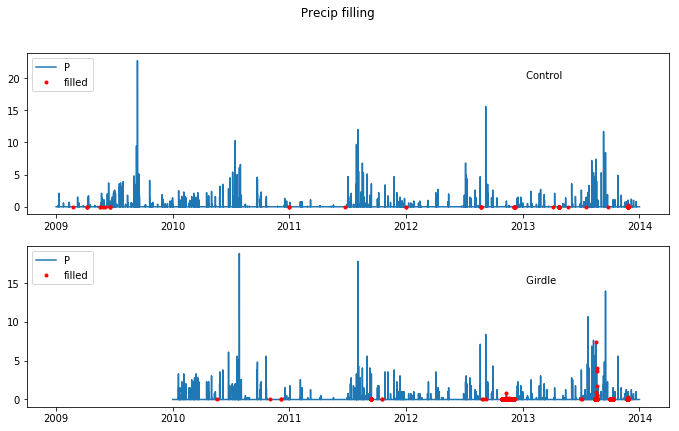

In [34]:

# Precip
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(hourly['Mpj'].index, hourly['Mpj'].P_F)
test = hourly['Mpj'].P_F_FLAG==1
plt.plot(hourly['Mpj'].index[test], hourly['Mpj'].loc[test, 'P_F'], 
         color='red', marker='.', ls='')
plt.legend(['P', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 20, ' Control ')
plt.suptitle(' Precip filling ')

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(hourly['Mpg'].index, hourly['Mpg'].P_F)
test = hourly['Mpg'].P_F_FLAG==1
plt.plot(hourly['Mpg'].index[test], hourly['Mpg'].loc[test, 'P_F'], 
         color='red', marker='.', ls='')
plt.legend(['P', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 15, ' Girdle ')
plt.show()

### Percent Precip gapfilled

In [35]:
df = pd.DataFrame()
gby = hourly['Mpj'].P_F_FLAG.groupby(hourly['Mpj'].index.year)
df['Mpj'] = gby.sum() / gby.count()
gby = hourly['Mpg'].P_F_FLAG.groupby(hourly['Mpg'].index.year)
df['Mpg'] = gby.sum() / gby.count()
df

,Mpj,Mpg
2009,0.000742,NaN
2010,0.000171,0.000228
2011,0.000228,0.001027
2012,0.000683,0.098076
2013,0.002626,0.034703
2014,1.000000,1.000000


## Substitute PRISM precip

In [76]:
prism_path = '/home/greg/sftp/eddyflux/Ancillary_met_data/PRISM_daily/'
prism_daily = pd.DataFrame()
site_file_list = os.listdir( prism_path )
#newidx = pd.date_range(str( startyear ) + '-01-01 00:30:00',
#                       str( endyear + 1 ) + '-01-01 00:00:00', freq = '30T')
for j in range(starty, endy + 1):
        fName = 'PRISM_DailyPrecip_{0}.csv'.format( str(j) )
        # If theres is a file for that year, load it
        if fName in site_file_list:
            # Call load_aflx_file
            year_df = pd.read_csv( prism_path + fName, index_col='date' )
            # And append to site_df
            prism_daily = prism_daily.append( year_df )
        else:
            print( 'WARNING: ' + fName + ' is missing')
prism_daily.loc[dt.date(2014, 1, 1), :] = np.nan
prism_daily.tail()

""
2014-01-01


In [77]:
# Find days that have any gapfilled precip
gby = hourly['Mpj'].P_F_FLAG.groupby([hourly['Mpj'].index.year, hourly['Mpj'].index.dayofyear])
test_Mpj = gby.sum() > 0
test_Mpj = test_Mpj.values # Discard index

gby = hourly['Mpg'].P_F_FLAG.groupby([hourly['Mpg'].index.year, hourly['Mpg'].index.dayofyear])
test_Mpg = gby.sum() > 0
test_Mpg = test_Mpg.values # Discard index
# Test that these are the correct length
len(test_Mpg) == len(d.Mpg.LE_F) and len(test_Mpj) == len(d.Mpj.LE_F)

AttributeError: 'DataFrame' object has no attribute 'LE_F'

In [78]:
# Add precip and replace gapfilled periods with PRISM
d.Mpj['P_F_PRISM'] = d.Mpj.P_F
d.Mpg['P_F_PRISM'] = d.Mpg.P_F
d.Mpj['P_F_FLAG'] = test_Mpj
d.Mpg['P_F_FLAG'] = test_Mpg

d.Mpj.loc[test_Mpj, 'P_F_PRISM'] = prism_daily['US-Mpj'][test_Mpj].values
d.Mpg.loc[test_Mpg, 'P_F_PRISM'] = prism_daily['US-Mpg'][test_Mpg].values

#Export for laura
d.Mpj.to_csv('processed_data/Mpj_daily_daytime_ET_PRISM.csv')
d.Mpg.to_csv('processed_data/Mpg_daily_daytime_ET_PRISM.csv')

AttributeError: 'DataFrame' object has no attribute 'P_F'

AttributeError: 'DataFrame' object has no attribute 'P_F_PRISM'

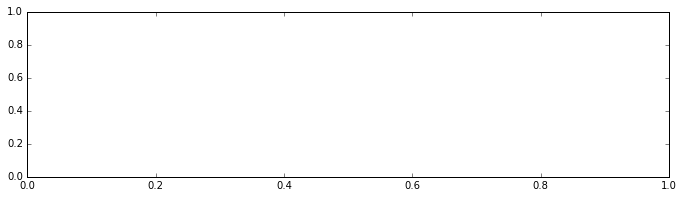

In [79]:
# Precip - filled with PRISM
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(d.Mpj.index, d.Mpj.P_F_PRISM)
test = d.Mpj.P_F_FLAG==True
plt.plot(d.Mpj.index[test], d.Mpj.loc[test, 'P_F_PRISM'], 
         color='red', marker='.', ls='')
plt.legend(['P', 'filled'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 20, ' Control ')
plt.suptitle(' Precip filling ')

ax2 = plt.subplot(2, 1, 2)
plt.plot(d.Mpg.index, d.Mpg.P_F_PRISM)
test = d.Mpg.P_F_FLAG==1
plt.plot(d.Mpg.index[test], d.Mpg.loc[test, 'P_F_PRISM'], 
         color='red', marker='.', ls='')
plt.legend(['P', 'filled by prism'], loc='upper left')
plt.text(dt.datetime(2013, 1, 1, 0, 0), 15, ' Girdle ')
plt.show()

# Add new PRISM precip columns to table
gby = d.Mpg.P_F_PRISM.groupby(d.Mpg.index.year)
df_P['Girdle Precip(Greg - PRISM)'] = gby.sum()
gby = d.Mpj.P_F_PRISM.groupby(d.Mpj.index.year)
df_P['Control Precip(Greg - PRISM)'] = gby.sum()
df_P